### Centre Recommendation

- [Data Checks on current centres](#data-checks-on-current-centres)
- [Data checks on potential Centres](#data-checks-on-potential-centres)
- [Linear and Random Forest Regression](#linear-and-random-forest-regression)
- [Pycaret AutoML Implementation](#pycaret-automl-implementation)
- [Feature Selection](#feature-selection)
- [Regularization](#regularization)
- [Cluster Analysis]()

### Data checks on current centres

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style('whitegrid')

# reading the data
current_centres = pd.read_excel("data/data.xlsx", sheet_name="Current Centres")
potential_centres = pd.read_excel("data/data.xlsx", sheet_name="Potential Centres")

print(current_centres.shape)
print(potential_centres.shape)

(1006, 13)
(100, 12)


In [2]:
encoding_map = {
    "A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6
}
current_centres["AREA_AFFLUENCE_GRADE"] = current_centres["AREA_AFFLUENCE_GRADE"].map(encoding_map)
potential_centres["AREA_AFFLUENCE_GRADE"] = potential_centres["AREA_AFFLUENCE_GRADE"].map(encoding_map)

In [3]:
# 1. check for missing values
print(current_centres.isnull().sum())

CENTRE_NO                         0
TYRE_BAYS                         0
MOT_BAYS                          0
SERVICE_BAYS                      0
TOTAL_STAFF                       0
AVG_DAILY_STAFF                   0
AVG_SALARY                        0
HOURS_OPEN_PER_WEEK               0
AREA_EV_PERC                     12
AREA_POPULATION_DENSITY_PPSKM    12
ANNUAL_RENT                       0
AREA_AFFLUENCE_GRADE              0
ANNUAL_REVENUE                    0
dtype: int64


In [4]:
# since the missing perc is 0.01% we can drop the rows
current_centres.dropna(inplace=True)

In [5]:
# 2. check for duplicates
print(current_centres.duplicated().sum())


7


In [6]:
# there were 7 duplicates which were dropped
current_centres.drop_duplicates(inplace=True)


In [7]:
# 3. check for skewness
current_centres.skew()

CENTRE_NO                       -0.004504
TYRE_BAYS                        0.034172
MOT_BAYS                         0.022325
SERVICE_BAYS                    -0.071075
TOTAL_STAFF                      0.137405
AVG_DAILY_STAFF                  0.329862
AVG_SALARY                       0.056933
HOURS_OPEN_PER_WEEK              0.067130
AREA_EV_PERC                    -0.172395
AREA_POPULATION_DENSITY_PPSKM    1.899128
ANNUAL_RENT                      0.762036
AREA_AFFLUENCE_GRADE             0.108029
ANNUAL_REVENUE                   1.114975
dtype: float64

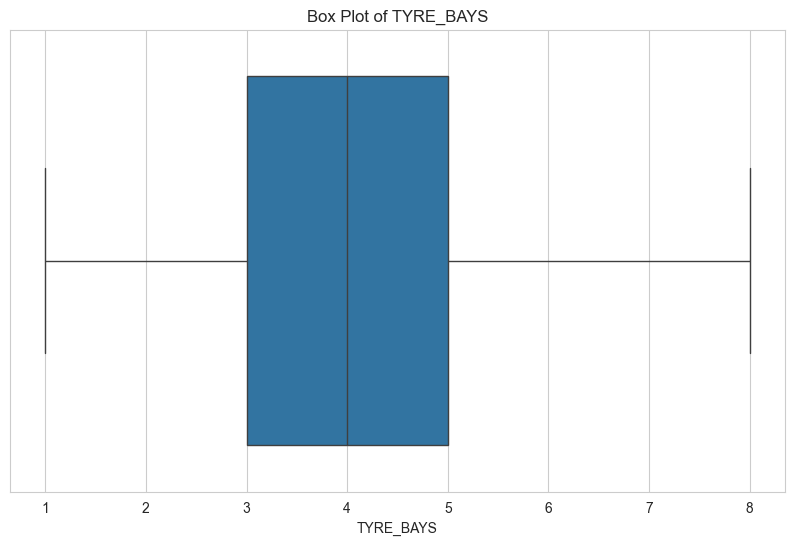

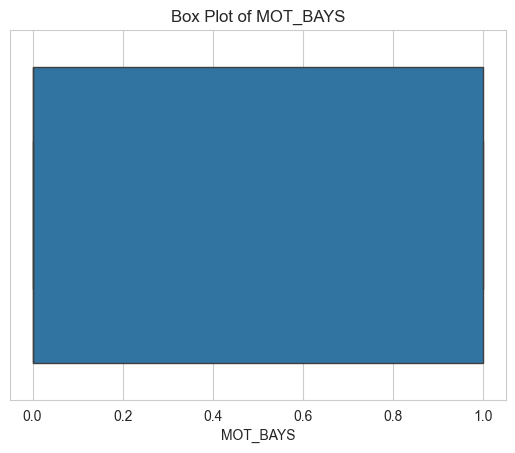

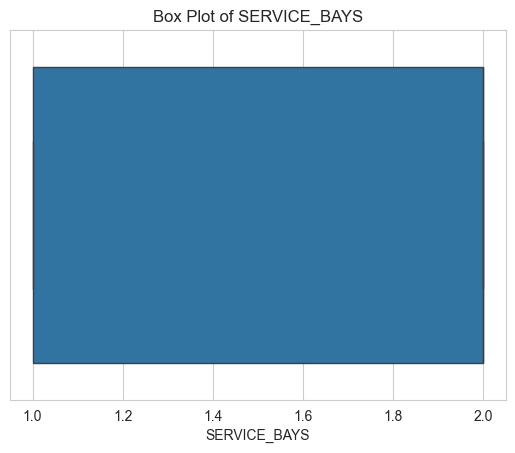

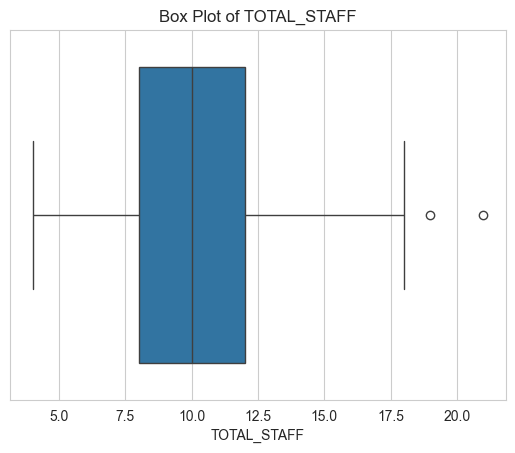

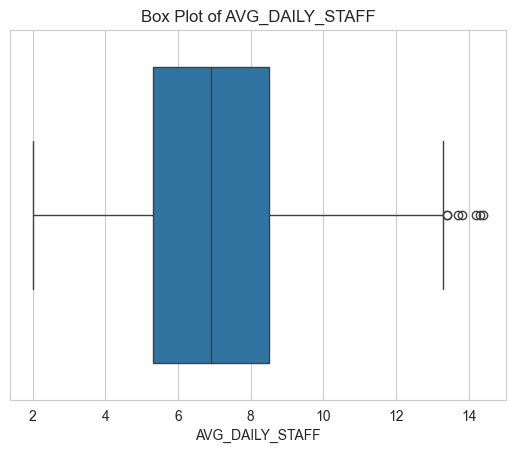

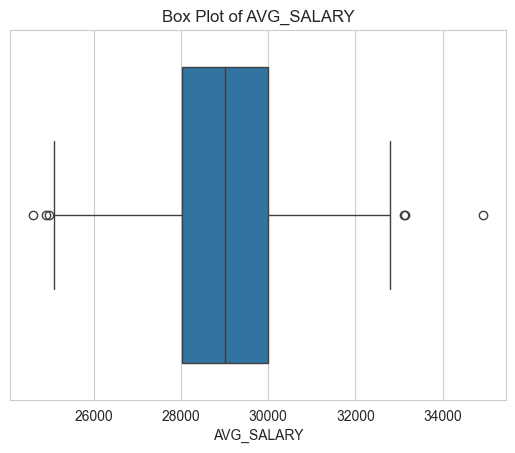

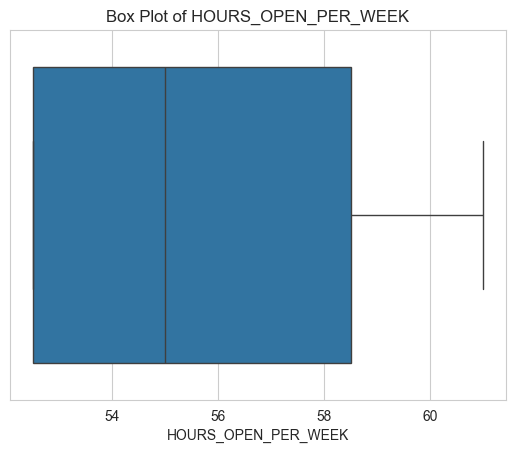

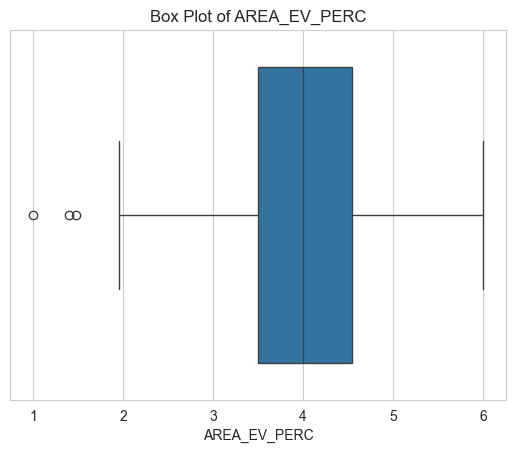

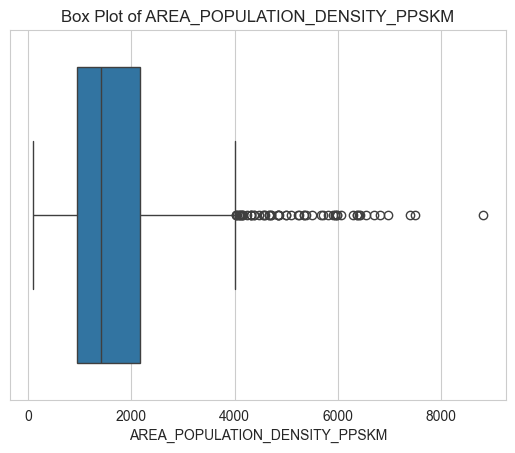

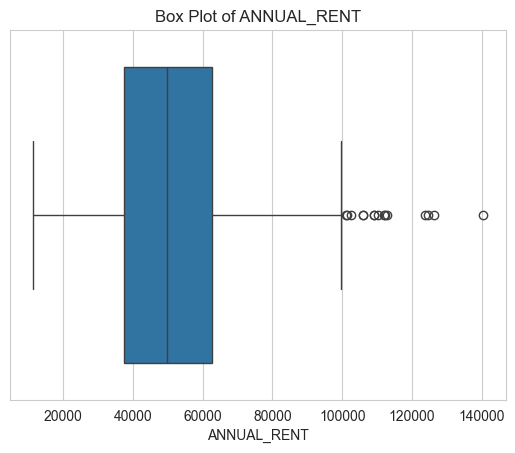

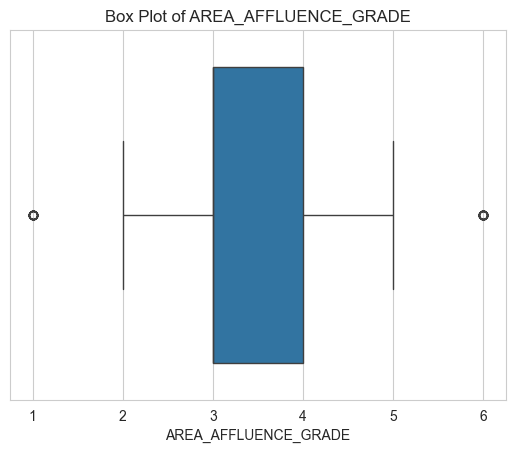

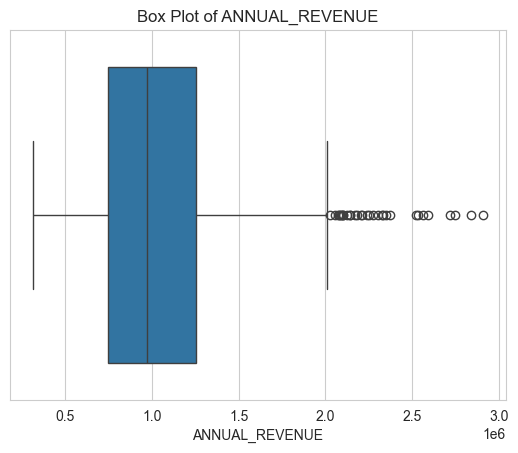

In [8]:
# 4. check for outliers
plt.figure(figsize=(10, 6))
for column in current_centres.drop('CENTRE_NO', axis=1).columns:
    sns.boxplot(x=current_centres[column])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
    plt.show()


In [9]:

# 5. Correlation analysis
# for the columns shortlisted in 3 and 4 are analyzed against the ANNUAL_REVENUE
columns_of_interest = [
    'AREA_POPULATION_DENSITY_PPSKM', 'AVG_DAILY_STAFF', 
    'AVG_SALARY', 'AREA_EV_PERC', 
    'ANNUAL_RENT', 'AREA_AFFLUENCE_GRADE']


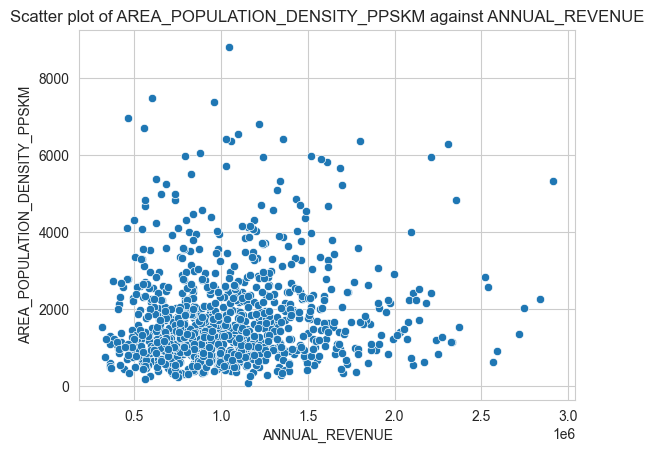

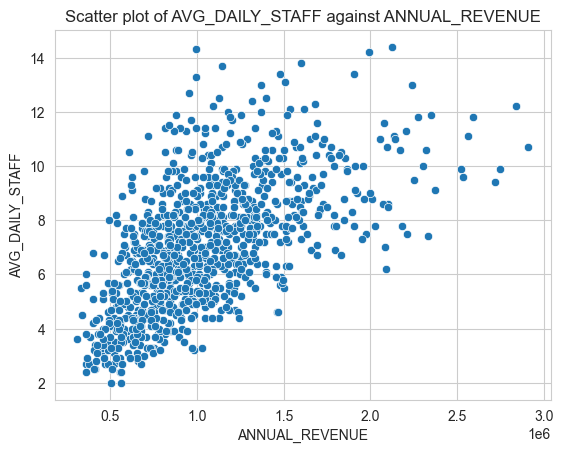

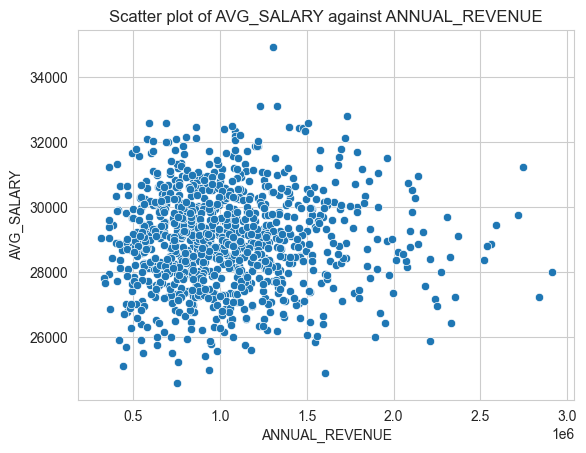

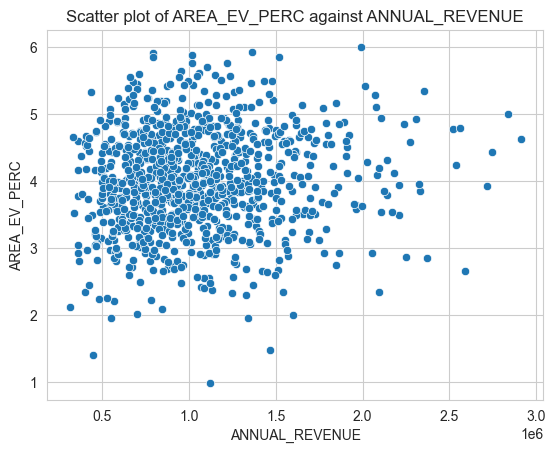

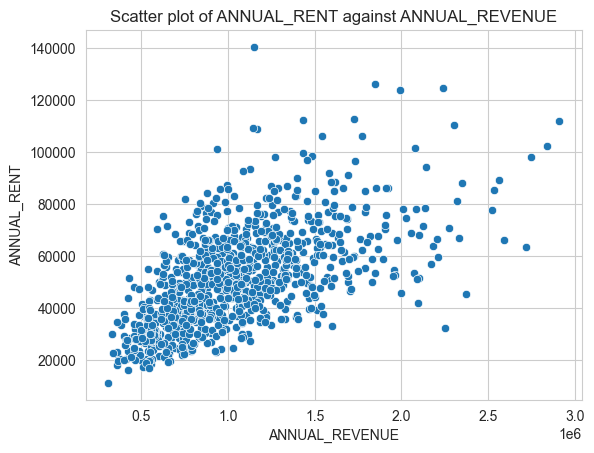

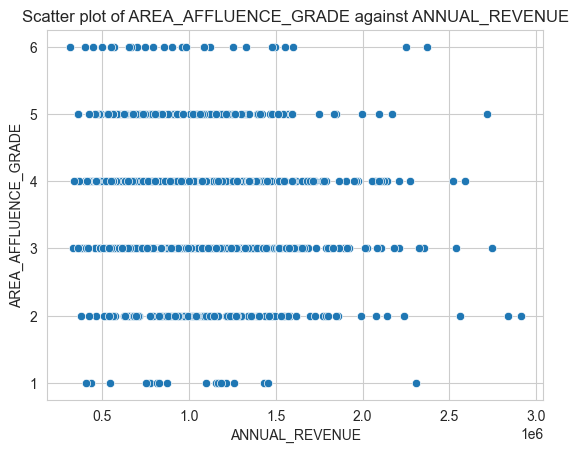

In [10]:
for column in columns_of_interest:
    sns.scatterplot(data=current_centres, y=column, x='ANNUAL_REVENUE')
    plt.title(f'Scatter plot of {column} against ANNUAL_REVENUE')
    plt.show()

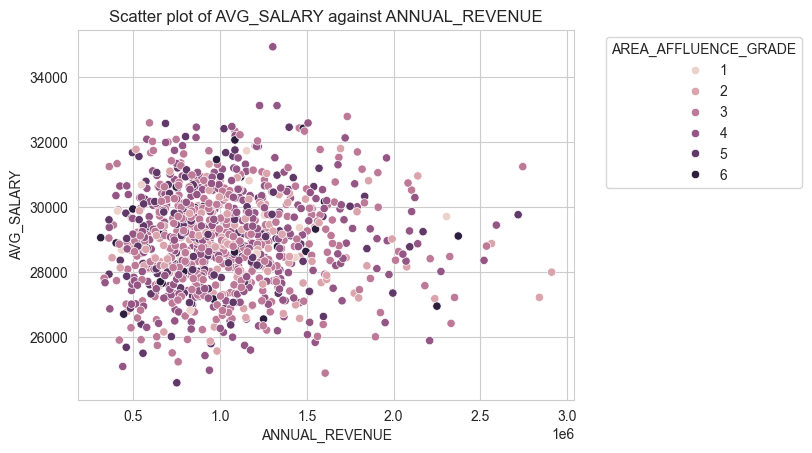

In [11]:
sns.scatterplot(
    data=current_centres, y='AVG_SALARY', x='ANNUAL_REVENUE', 
    hue='AREA_AFFLUENCE_GRADE')
plt.title('Scatter plot of AVG_SALARY against ANNUAL_REVENUE')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, title='AREA_AFFLUENCE_GRADE')
plt.show()

In [12]:
# what is the reason that the annual revenue is high ? 
# how many such centres are there ?

sub_df = current_centres[current_centres['ANNUAL_REVENUE'] > 2000000]
sub_df.shape

(33, 13)

In [13]:
33 / current_centres.shape[0] * 100

3.343465045592705

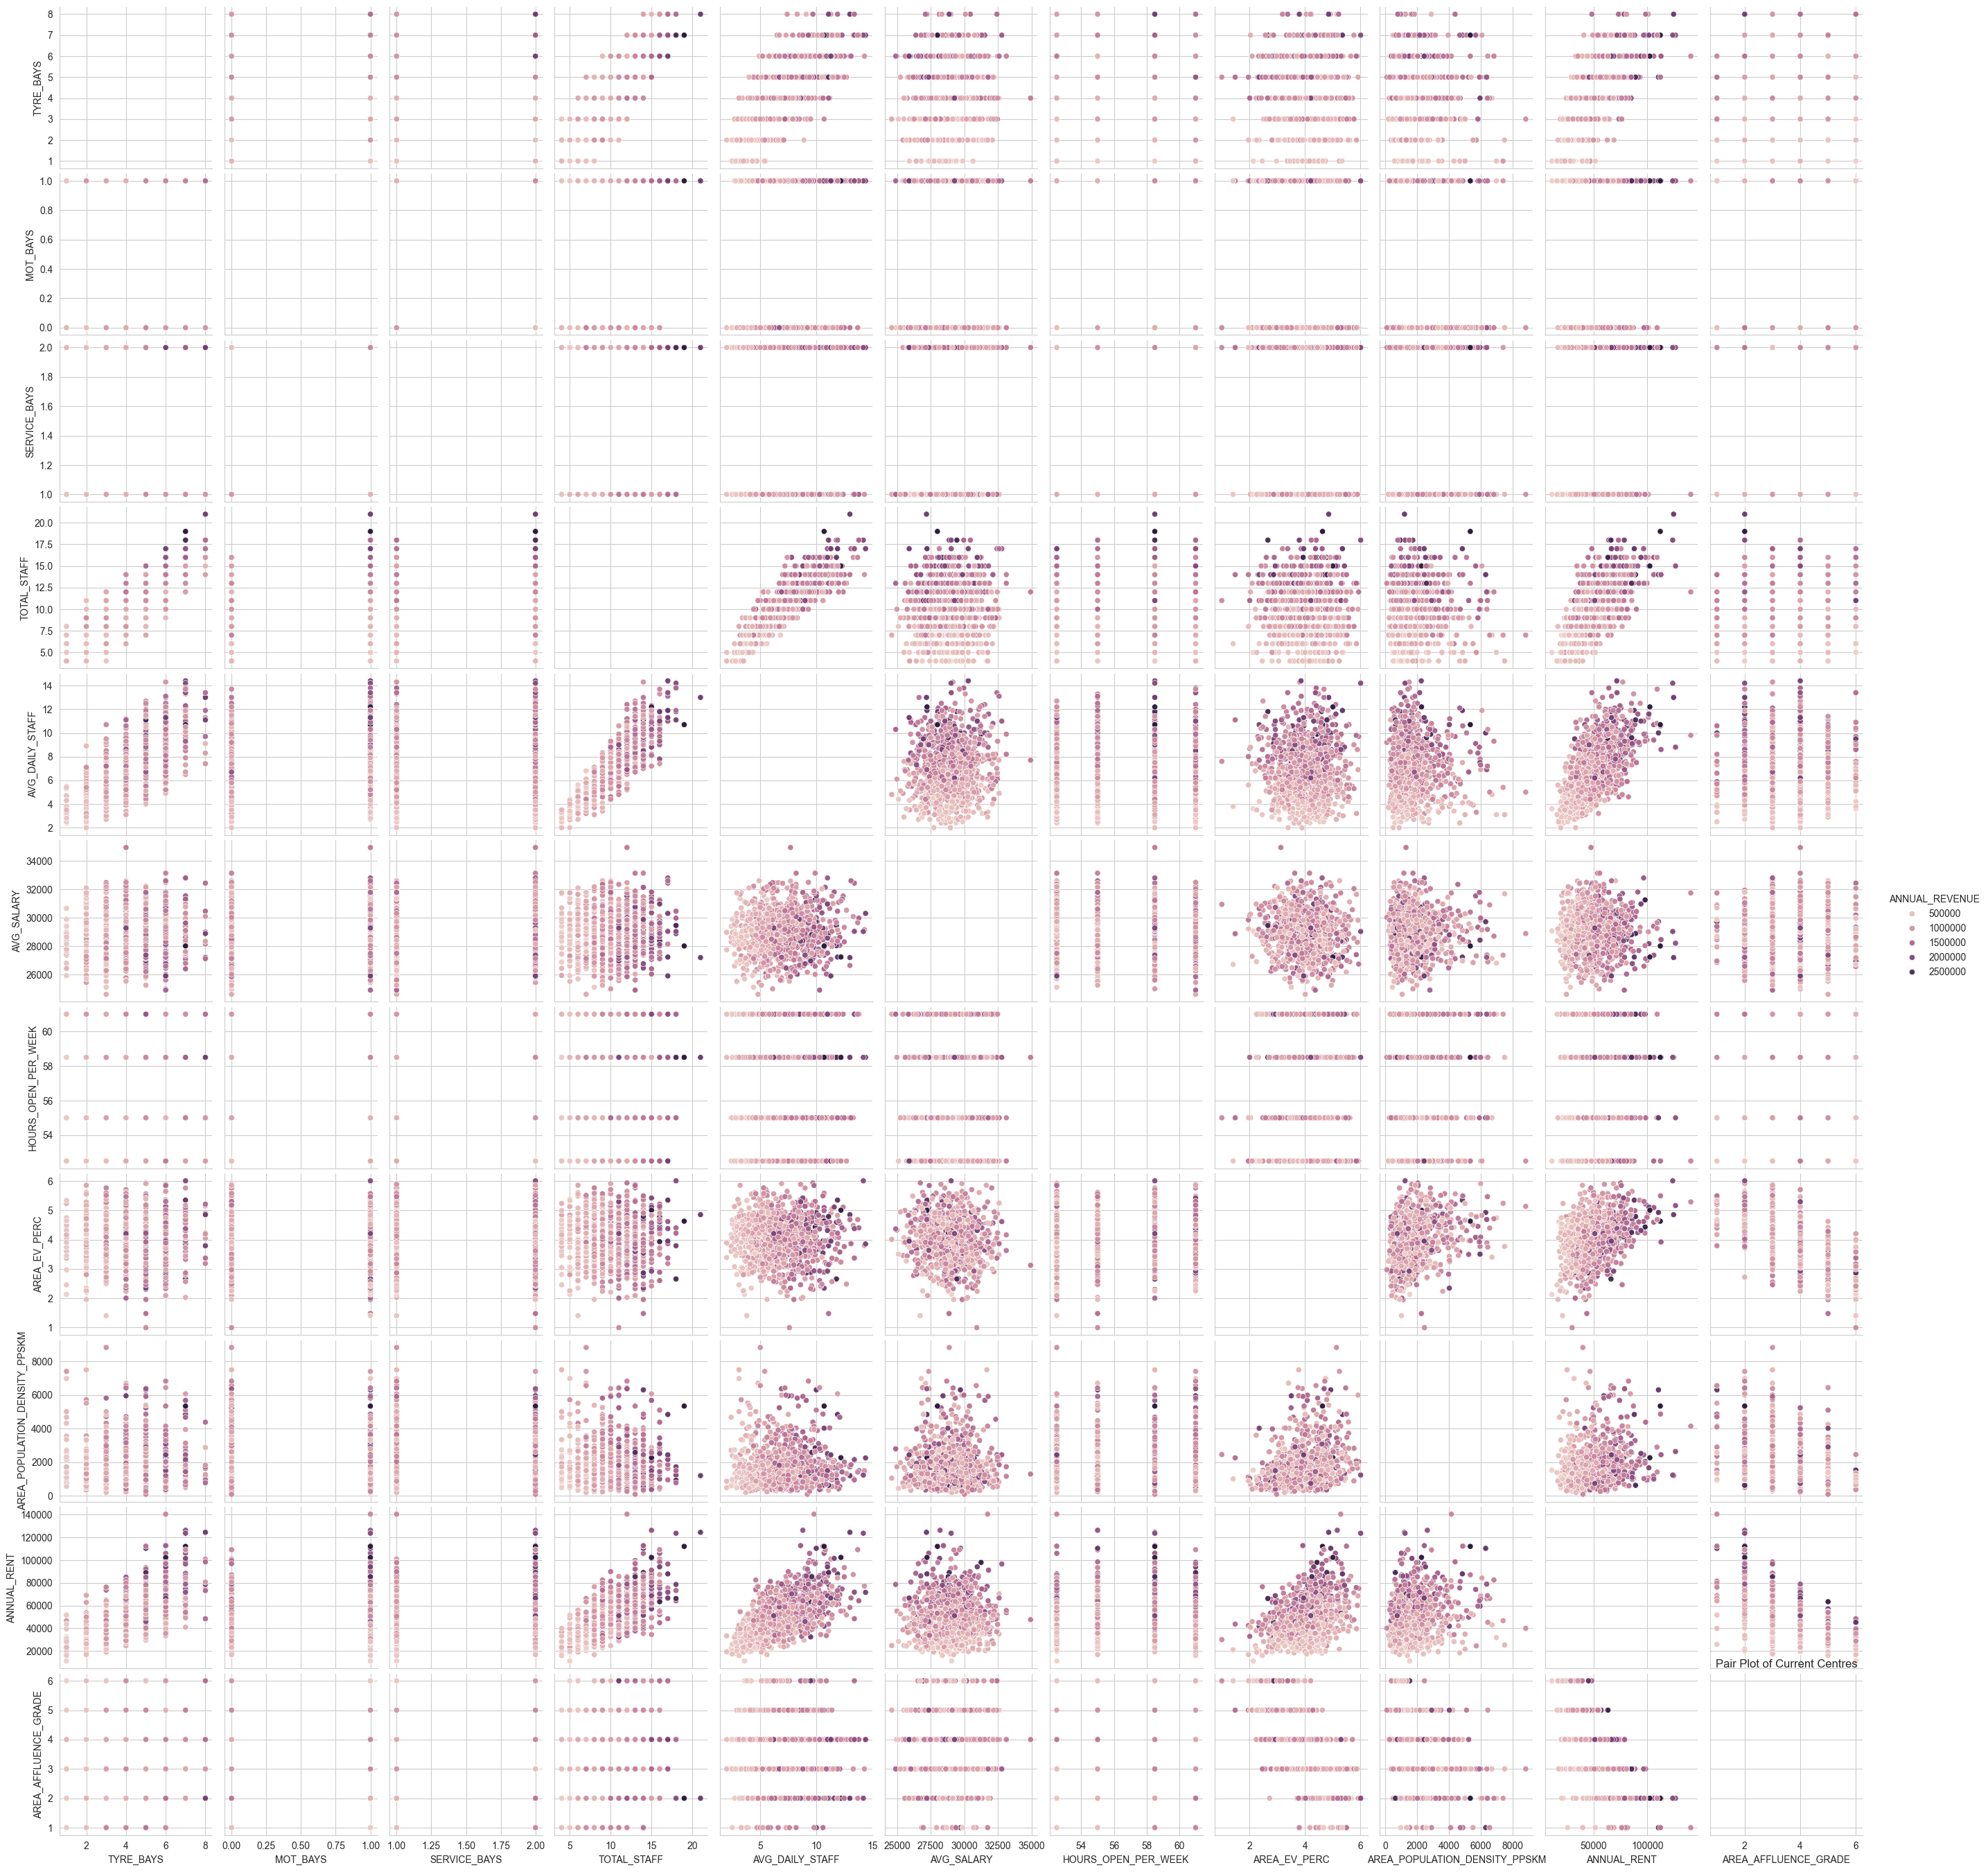

In [14]:
# 6. Pair plot
# to understand more in detail of the relationships between the features

sns.pairplot(current_centres.drop('CENTRE_NO', axis=1), hue="ANNUAL_REVENUE")
plt.title('Pair Plot of Current Centres')
plt.show()

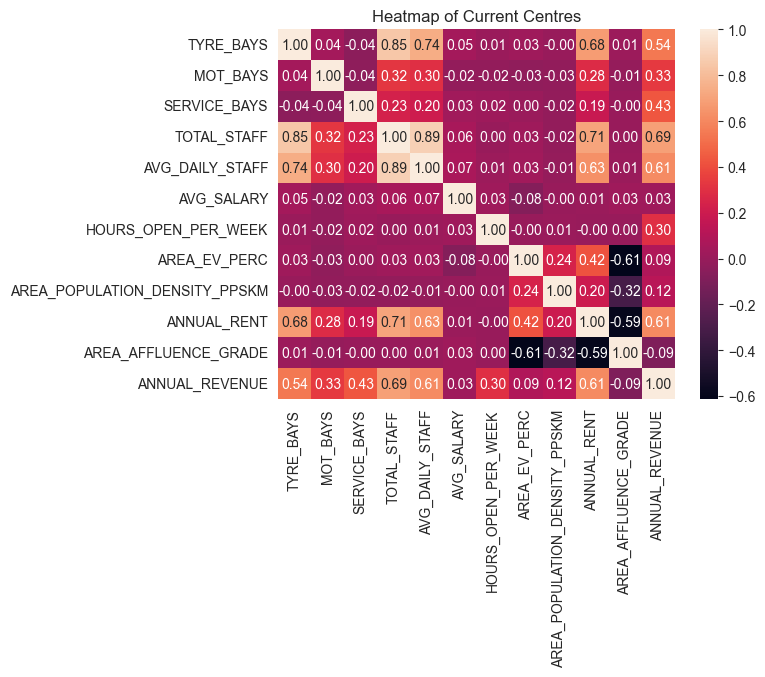

In [15]:
# 6. Correlation analysis part 3: heatmap
# to understand more in detail of the relationships between the features
sns.heatmap(current_centres.drop('CENTRE_NO', axis=1).corr(), fmt='.2f', annot=True)
plt.title('Heatmap of Current Centres')
plt.show()

In [41]:
sub_df = current_centres[current_centres['ANNUAL_REVENUE'] <= 2000000]
sub_df.shape, current_centres.shape

((954, 13), (987, 13))

In [42]:
sub_df.skew()

CENTRE_NO                        0.004371
TYRE_BAYS                        0.036122
MOT_BAYS                         0.088275
SERVICE_BAYS                    -0.008399
TOTAL_STAFF                      0.047828
AVG_DAILY_STAFF                  0.334672
AVG_SALARY                       0.053006
HOURS_OPEN_PER_WEEK              0.110922
AREA_EV_PERC                    -0.164678
AREA_POPULATION_DENSITY_PPSKM    1.912820
ANNUAL_RENT                      0.723801
AREA_AFFLUENCE_GRADE             0.101101
ANNUAL_REVENUE                   0.523430
dtype: float64

### Linear and Random Forest Regression

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

In [17]:
from sklearn.ensemble import RandomForestRegressor

In [51]:
from sklearn.model_selection import train_test_split

In [18]:
sub_df = current_centres[current_centres['ANNUAL_REVENUE'] <= 2000000]
sub_df.shape, current_centres.shape

((954, 13), (987, 13))

In [ ]:
# 7. Select the columns
columns_subset = [
    "AVG_DAILY_STAFF", "AREA_EV_PERC",
    "HOURS_OPEN_PER_WEEK", "ANNUAL_RENT",
    "TOTAL_STAFF", "AREA_AFFLUENCE_GRADE",
    "MOT_BAYS", "SERVICE_BAYS"
]

target_column = "ANNUAL_REVENUE"


In [88]:
x_train, x_test, y_train, y_test = train_test_split(
    sub_df[columns_subset], sub_df[target_column], test_size=0.2, random_state=42,
    shuffle=True
)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((763, 9), (191, 9), (763,), (191,))

In [89]:
model1 = RandomForestRegressor()
model1.fit(x_train, y_train)
model2 = LinearRegression()
model2.fit(x_train, y_train)

LinearRegression()

In [90]:
model1 = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
model1.fit(x_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=50, random_state=42)

In [91]:
predictions = model1.predict(x_test)

print("Mean Absolute Error: ", round(
    mean_absolute_error(y_test, predictions), 3))
print("R2 Score: ", round(
    r2_score(y_test, predictions), 3))
print("Root Mean Squared Error: ", round(
    root_mean_squared_error(y_test, predictions), 3))

Mean Absolute Error:  154150.595
R2 Score:  0.674
Root Mean Squared Error:  198062.855


In [92]:
predictions = model2.predict(x_test)

print("Mean Absolute Error: ", round(
    mean_absolute_error(y_test, predictions), 3))
print("R2 Score: ", round(
    r2_score(y_test, predictions), 3))
print("Root Mean Squared Error: ", round(
    root_mean_squared_error(y_test, predictions), 3))

Mean Absolute Error:  151811.773
R2 Score:  0.683
Root Mean Squared Error:  195475.632


### Pycaret AutoML implementation

In [23]:
from pycaret.regression import *

reg = setup(
    data=sub_df[columns_subset + ["ANNUAL_REVENUE"]],
    target='ANNUAL_REVENUE',
    session_id=123,
    normalize=False,
    transformation=False,
    preprocess=False,
    ignore_features=['CENTRE_NO']
)

best_model = compare_models()


,Description,Value
0,Session id,123
1,Target,ANNUAL_REVENUE
2,Target type,Regression
3,Original data shape,"(954, 10)"
4,Transformed data shape,"(954, 10)"
5,Transformed train set shape,"(667, 10)"
6,Transformed test set shape,"(287, 10)"
7,Ignore features,1
8,Numeric features,9


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,152331.6929,37929169119.4787,194180.6073,0.6797,0.2025,0.1671,0.0720
lr,Linear Regression,154042.4208,38325211126.6114,195039.1266,0.6789,0.2113,0.1723,1.2150
lasso,Lasso Regression,154042.3839,38325143923.5076,195038.9557,0.6789,0.2113,0.1723,0.7050
ridge,Ridge Regression,154048.1427,38322359029.5433,195030.9700,0.6789,0.2112,0.1722,0.0140
llar,Lasso Least Angle Regression,154042.3839,38325143881.5696,195038.9556,0.6789,0.2113,0.1723,0.0140
lar,Least Angle Regression,154288.6457,38551537239.0068,195623.1323,0.6773,0.2139,0.1725,0.0150
lightgbm,Light Gradient Boosting Machine,154172.7688,38820720073.2256,196477.2173,0.6730,0.2078,0.1698,0.1550
rf,Random Forest Regressor,155265.0656,39227916480.5653,197497.1363,0.6677,0.2080,0.1730,0.1220
et,Extra Trees Regressor,159084.6390,39534649699.6786,198243.8895,0.6656,0.2068,0.1749,0.0830
en,Elastic Net,163242.1854,43642180323.6562,208161.1238,0.6321,0.2121,0.1790,0.0130


In [39]:
best_model

GradientBoostingRegressor(random_state=123)

### Data checks on potential centres

In [24]:
potential_centres.head()

,CENTRE_NO,TYRE_BAYS,MOT_BAYS,SERVICE_BAYS,TOTAL_STAFF,AVG_DAILY_STAFF,AVG_SALARY,HOURS_OPEN_PER_WEEK,AREA_EV_PERC,AREA_POPULATION_DENSITY_PPSKM,ANNUAL_RENT,AREA_AFFLUENCE_GRADE
0,58,5,0,1,9,4.7,24366,58.5,3.830469,2241.900879,51400,3
1,74,5,1,2,15,9.6,26565,58.5,4.628830,2092.164975,69700,3
2,23,6,0,1,9,5.7,29536,61.0,4.573076,2002.121410,53100,4
3,33,3,1,2,11,7.7,28167,61.0,2.722832,657.454164,27600,6
4,94,5,1,1,11,6.3,28381,61.0,4.602026,1861.169972,64600,3


In [28]:
print(potential_centres.isnull().sum())

CENTRE_NO                        0
TYRE_BAYS                        0
MOT_BAYS                         0
SERVICE_BAYS                     0
TOTAL_STAFF                      0
AVG_DAILY_STAFF                  0
AVG_SALARY                       0
HOURS_OPEN_PER_WEEK              0
AREA_EV_PERC                     1
AREA_POPULATION_DENSITY_PPSKM    1
ANNUAL_RENT                      0
AREA_AFFLUENCE_GRADE             0
dtype: int64


In [30]:
potential_centres.dropna(inplace=True)

In [31]:
print(potential_centres.duplicated().sum())

0


In [32]:
print(potential_centres.skew())

CENTRE_NO                        0.003695
TYRE_BAYS                        0.259444
MOT_BAYS                        -0.485099
SERVICE_BAYS                    -0.185395
TOTAL_STAFF                      0.083565
AVG_DAILY_STAFF                  0.550440
AVG_SALARY                      -0.194657
HOURS_OPEN_PER_WEEK              0.176845
AREA_EV_PERC                     0.073271
AREA_POPULATION_DENSITY_PPSKM    2.496019
ANNUAL_RENT                      0.722898
AREA_AFFLUENCE_GRADE            -0.179237
dtype: float64


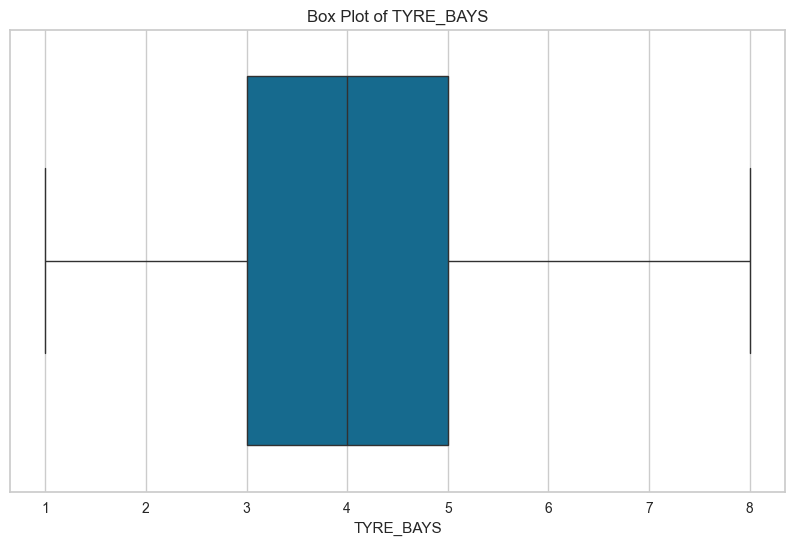

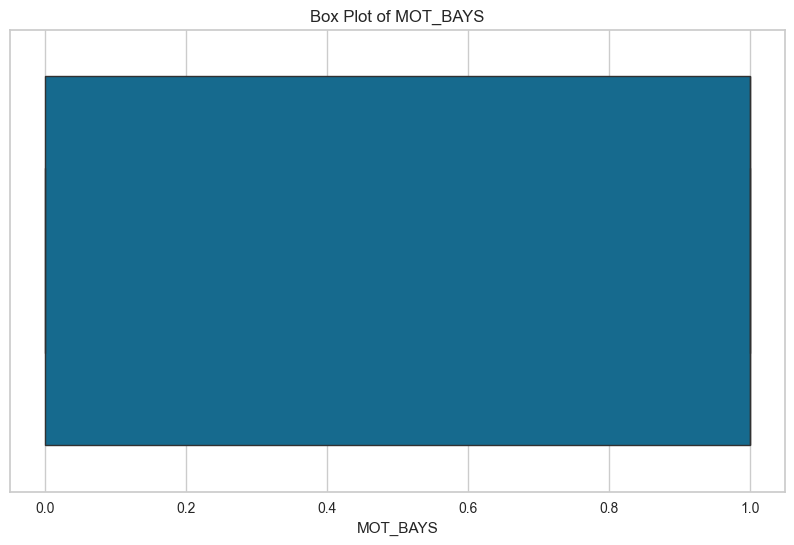

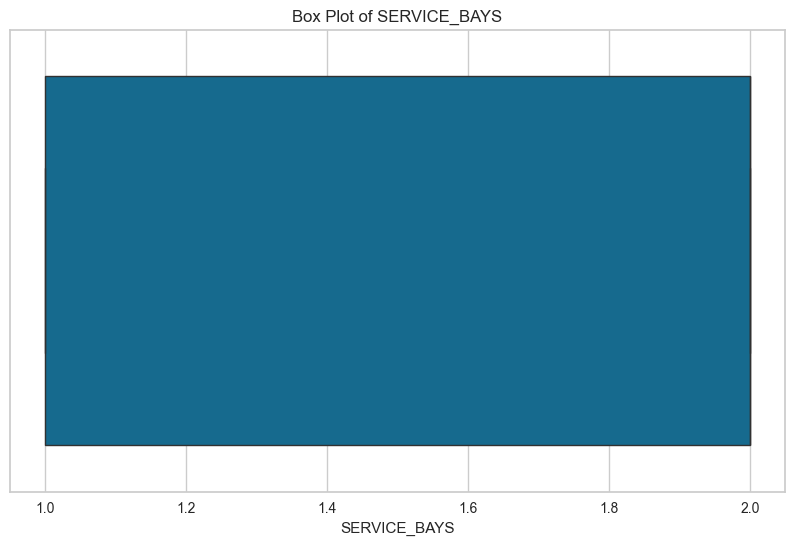

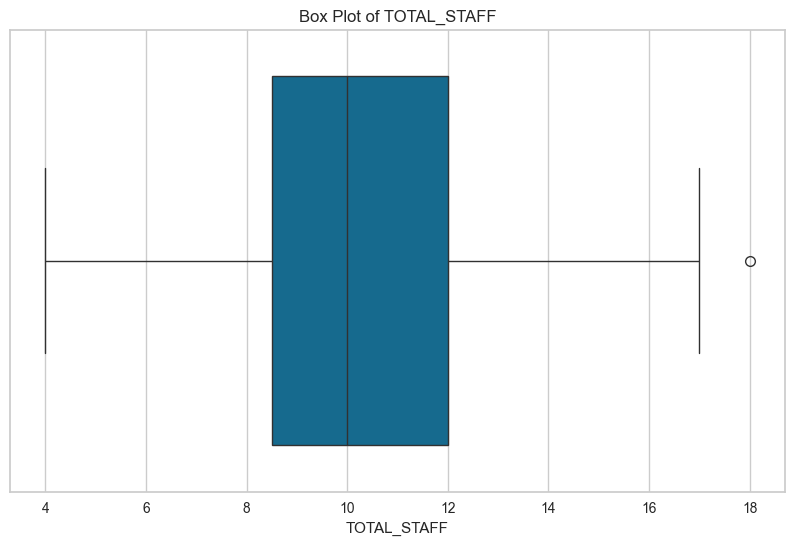

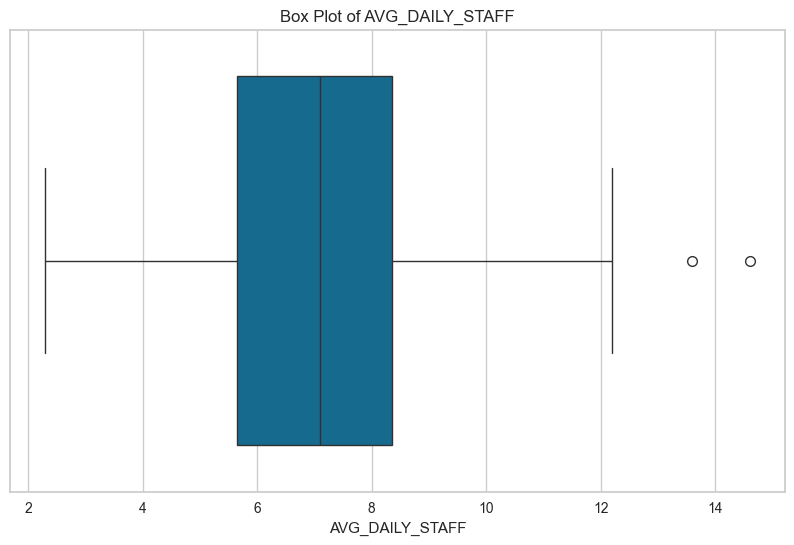

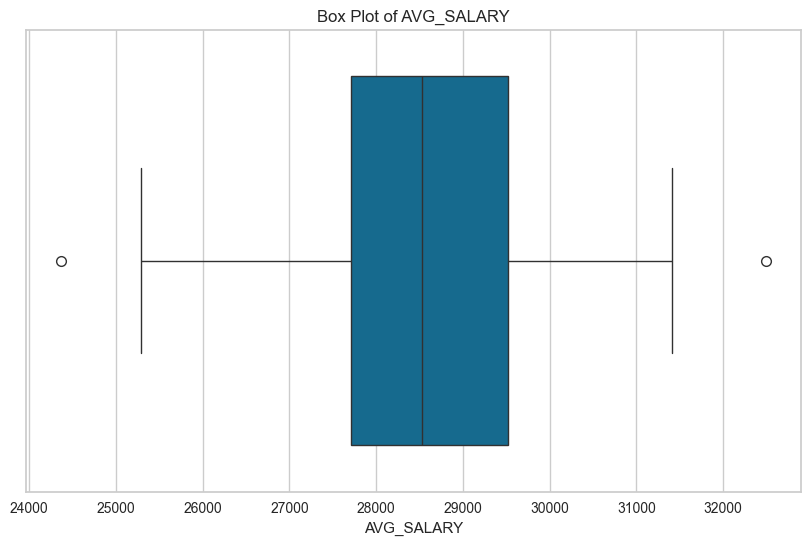

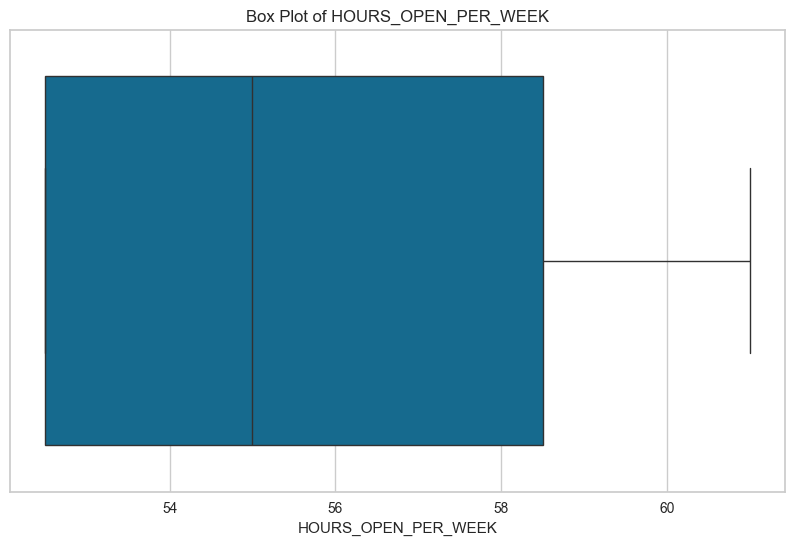

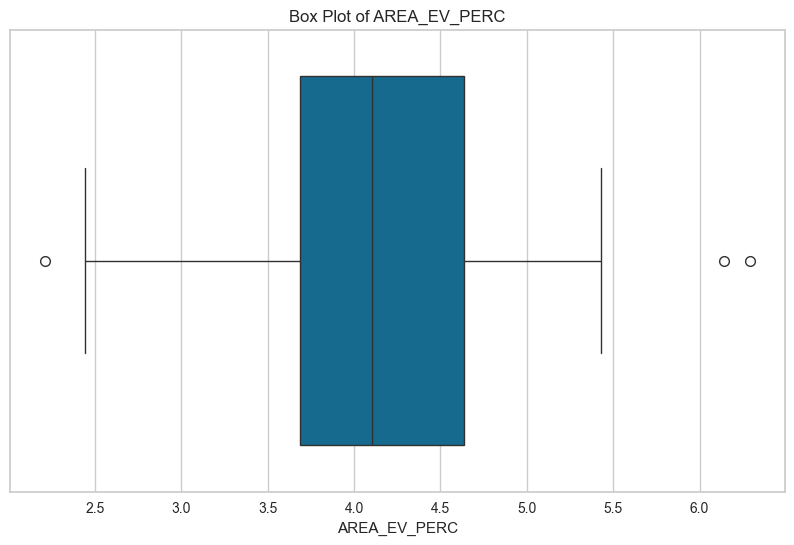

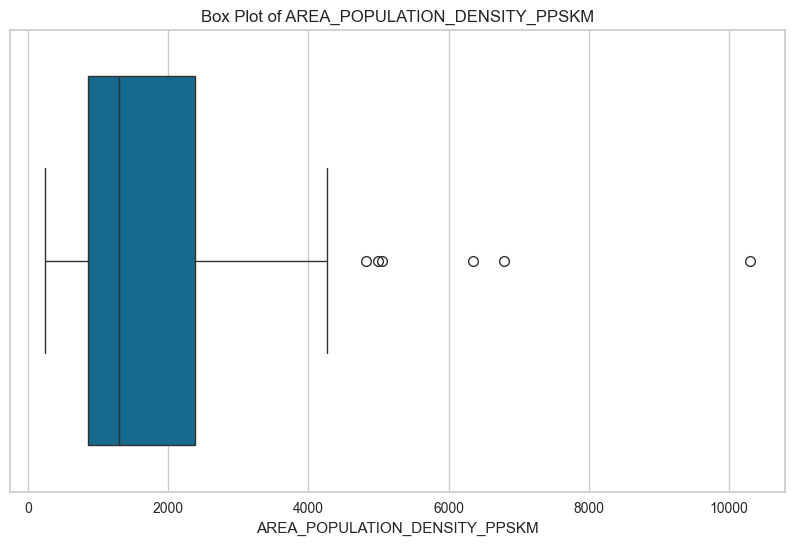

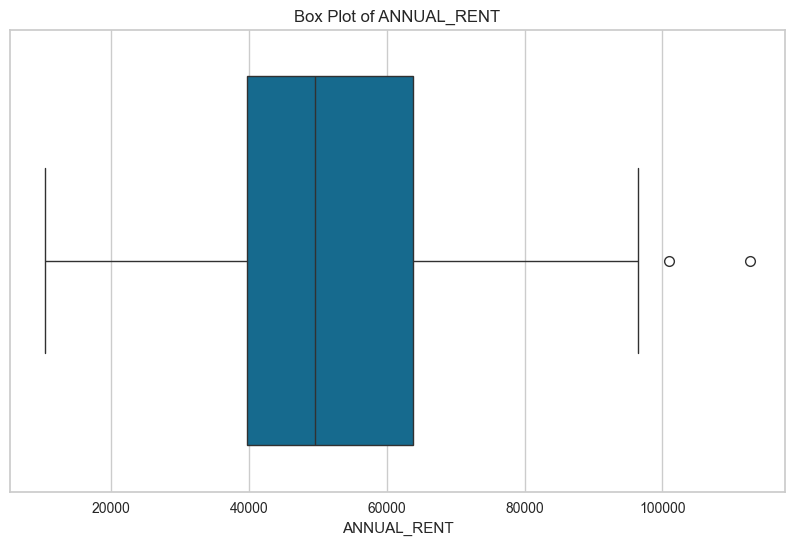

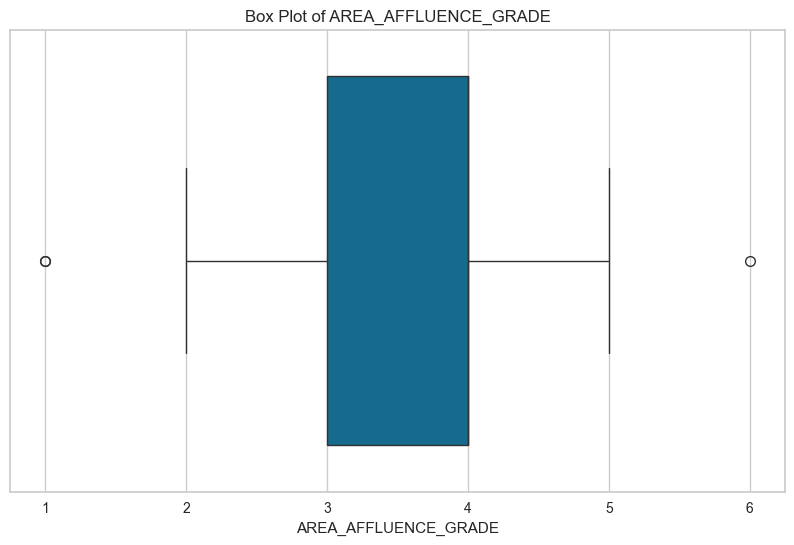

In [43]:
for column in potential_centres.drop('CENTRE_NO', axis=1).columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=potential_centres[column])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
    plt.show()

### Feature Selection

In [ ]:
x_data = sub_df.drop(["ANNUAL_REVENUE", "CENTRE_NO"], axis=1)
y_data = sub_df["ANNUAL_REVENUE"]

feature_selection_model = RandomForestRegressor()
feature_selection_model.fit(x_data, y_data)
feature_selection_model.feature_importances_

array([0.03564695, 0.04931917, 0.10716225, 0.39610236, 0.05303996,
       0.04242162, 0.09704822, 0.03507371, 0.05838341, 0.11733908,
       0.00846326])

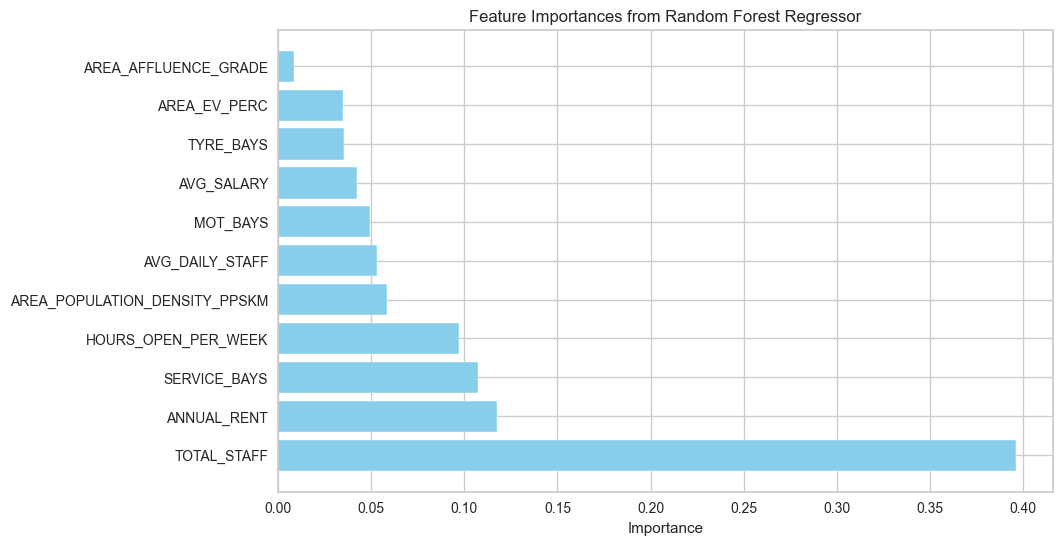

In [75]:
importances = feature_selection_model.feature_importances_
feature_names = x_data.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest Regressor')
plt.show()

### Regularization

In [85]:
from sklearn.linear_model import Lasso, Ridge

In [93]:
model3 = Ridge()
model3.fit(x_train, y_train)

predictions = model3.predict(x_test)

print("Mean Absolute Error: ", round(
    mean_absolute_error(y_test, predictions), 3))
print("R2 Score: ", round(
    r2_score(y_test, predictions), 3))
print("Root Mean Squared Error: ", round(
    root_mean_squared_error(y_test, predictions), 3))

Mean Absolute Error:  151811.93
R2 Score:  0.683
Root Mean Squared Error:  195481.145


In [84]:
coeff_ = model3.coef_
selected_features = x_train.columns[coeff_ != 0]
selected_coeff = coeff_[coeff_ != 0]

result_df = pd.DataFrame({'Feature': selected_features, 'Coefficient': selected_coeff})
result_df.sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient
7,SERVICE_BAYS,212766.965555
6,MOT_BAYS,82301.652563
4,TOTAL_STAFF,48651.518768
5,AREA_AFFLUENCE_GRADE,36601.907069
2,HOURS_OPEN_PER_WEEK,31907.953049
8,AREA_POPULATION_DENSITY_PPSKM,31.768674
3,ANNUAL_RENT,6.476224
0,AVG_DAILY_STAFF,-8409.846878
1,AREA_EV_PERC,-15926.051744


In [94]:
from sklearn.preprocessing import StandardScaler

In [97]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

lm_1, lm_2, lm_3 = LinearRegression(), Lasso(), Ridge()

lm_1.fit(x_train_scaled, y_train)
lm_2.fit(x_train_scaled, y_train)
lm_3.fit(x_train_scaled, y_train)

Ridge()

In [98]:
pred1 = lm_1.predict(x_test_scaled)

print("Mean Absolute Error: ", round(
    mean_absolute_error(y_test, pred1), 3))
print("R2 Score: ", round(
    r2_score(y_test, pred1), 3))
print("Root Mean Squared Error: ", round(
    root_mean_squared_error(y_test, pred1), 3))


Mean Absolute Error:  152963.013
R2 Score:  0.687
Root Mean Squared Error:  194153.034


In [99]:
pred2 = lm_2.predict(x_test_scaled)

print("Mean Absolute Error: ", round(
    mean_absolute_error(y_test, pred2), 3))
print("R2 Score: ", round(
    r2_score(y_test, pred2), 3))
print("Root Mean Squared Error: ", round(
    root_mean_squared_error(y_test, pred2), 3))


Mean Absolute Error:  152962.847
R2 Score:  0.687
Root Mean Squared Error:  194152.625


In [100]:
pred3 = lm_3.predict(x_test_scaled)

print("Mean Absolute Error: ", round(
    mean_absolute_error(y_test, pred3), 3))
print("R2 Score: ", round(
    r2_score(y_test, pred3), 3))
print("Root Mean Squared Error: ", round(
    root_mean_squared_error(y_test, pred3), 3))


Mean Absolute Error:  152952.946
R2 Score:  0.687
Root Mean Squared Error:  194111.107


In [101]:
from sklearn.linear_model import LassoCV

In [107]:
lm_4 = LassoCV(cv=20, random_state=42)
lm_4.fit(x_train, y_train)

LassoCV(cv=20, random_state=42)

In [108]:
pred4 = lm_4.predict(x_test)

print("Mean Absolute Error: ", round(
    mean_absolute_error(y_test, pred4), 3))
print("R2 Score: ", round(
    r2_score(y_test, pred4), 3))
print("Root Mean Squared Error: ", round(
    root_mean_squared_error(y_test, pred4), 3))


Mean Absolute Error:  206997.943
R2 Score:  0.397
Root Mean Squared Error:  269570.858


In [109]:
mean_prediction = y_test.mean()
median_prediction = y_test.median()

mean_prediction, median_prediction

(1004487.3520149176, 959724.297952189)

### Cluster Analysis